In [29]:
import numpy
import AGG
import pandas as pd
import pysam
import seaborn as sns

In [5]:
# get variant table
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Variant:
    pos: int          # Position on reference
    ref_allele: str   # Reference allele
    alt_allele: str   # Alternative allele
    variant_type: str # Type of variant (SNP, INS, DEL)
    allele_count: int # how many reads supporting
    
def get_variant_from_cigar(cigar: str, ref_seq: str, alt_seq: str, ref_start: int, allelecount: int) -> List[Variant]:
    """
    Extract variants from a CIGAR string comparing reference and alternate sequences.
    
    Args:
        cigar: CIGAR string (e.g., "5=1X2=1I3=2D1=")
        ref_seq: Reference sequence
        alt_seq: Alternate sequence
        ref_start: Starting position on reference (default 0)
    
    Returns:
        List of Variant objects
    """
    variants = []
    poscount = {}
    ref_pos = 0
    alt_pos = 0
    
    # Parse CIGAR string into operations
    operations = []
    num = ""
    for c in cigar:
        if c.isdigit():
            num += c
        else:
            operations.append((int(num), c))
            num = ""
    
    # Process each operation
    for length, op in operations:
        if op == '=':  # Match
            ref_pos += length
            alt_pos += length
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
        elif op == 'X':  # Mismatch
            for i in range(length):
                pos=ref_start + ref_pos + i
                ref_allele=ref_seq[ref_pos + i]
                alt_allele=alt_seq[alt_pos + i]
                poscount[pos] = poscount.get(pos, 0) + allelecount
                variants.append(Variant(
                    pos,
                    ref_allele,
                    alt_allele,
                    variant_type="SNP",
                    allele_count=allelecount
                ))
            ref_pos += length
            alt_pos += length

        elif op == 'I':  # Insertion
            pos=ref_start + ref_pos
            try:
                ref_allele=ref_seq[ref_pos-1]
            except:
                print(ref_seq, len(ref_seq), ref_pos)
                ref_allele = "-"
            alt_allele=alt_seq[alt_pos-1:alt_pos + length]
            if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
                print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="INS",
                allele_count=allelecount
            ))
            alt_pos += length
            
        elif op == 'D':  # Deletion
            pos=ref_start + ref_pos
            ref_allele=ref_seq[ref_pos-1:ref_pos + length]
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
                
            try:
                alt_allele=alt_seq[alt_pos-1]
            except:
                print(alt_seq, len(alt_seq), alt_pos)
                alt_allele = "-"
            if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
                print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="DEL",
                allele_count=allelecount
            ))
            ref_pos += length
            
    return variants, poscount

def findBedge(Graph, src, dst, refstrain, k):
    # revision add first anchor
    paths = AGG.Find_all_Path_between_anchors(Graph, src, dst, {refstrain})
    subpaths = paths.subpath
    
    if len(subpaths) < 1:
        return ""
    for p, strain in subpaths:
        seq = AGG.reconstruct_path_seq(Graph, path = p)
    return seq[:-k] 

def get_variants(graph, k, ref_name, threshold):
    Var = []
    Record = {}
    coverage = {}
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        allele_count = len(graph.edges[edge].get('reads', []))
        readlist = graph.edges[edge]['reads']
        if allele_count <= threshold:
            continue
        cigar = graph.edges[edge].get('variants', "")
        if cigar == "":
            continue

        src = graph.incoming[edge][0]
        dst = graph.outgoing[edge][0]

        if src == "SOURCE" or dst == "SINK":
            continue

        refstart = int(graph.anchor[src]["pos"]) # start from the src anchor
        if dst < src:
            continue
        
        ref_seq = findBedge(graph, src, dst, ref_name, k)
        alt_seq = graph.anchor.get(src, {}).get("seq", "") + graph.edges[edge]['seq']
        variants, poscount = get_variant_from_cigar(cigar, ref_seq, alt_seq, refstart, allele_count) 
        Var += variants
        for pos, count in poscount.items():
            coverage[pos] = coverage.get(pos, 0) + count
        for v in variants:
            if v.variant_type == "SNP":
                key = "m.%s%s>%s" % (v.pos + 1, v.ref_allele, v.alt_allele)
            else:
                key = "m.%s%s>%s" % (v.pos, v.ref_allele, v.alt_allele)
            Record[key] = Record.get(key, []) + readlist

    return Var, Record, coverage

def find_all_reads(graph, ref = "NC_012920.1"):
    read_set = []
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        readlist = graph.edges[edge]['reads']
        read_set += readlist
    read_set = list(set(read_set) - {ref})
    return read_set

In [12]:
filename = "./mt_test.annotated.gfa"
graph = AGG.GraphicalGenome(filename)
Var, Record, coverage = get_variants(graph, 21, "chrM", threshold=2)

read_set = sorted(find_all_reads(graph,ref="chrM"))
read_set_dict = dict(zip(read_set, range(len(read_set))))
var_record = []
for v in Var:
    if v.variant_type == "SNP":
        var_record.append("m.%s%s>%s" % (v.pos + 1, v.ref_allele, v.alt_allele))
    else:
        var_record.append("m.%s%s>%s" % (v.pos, v.ref_allele, v.alt_allele))

var_record = sorted(set(var_record))
var_record_dict = dict(zip(var_record, range(len(var_record))))

matrix = numpy.zeros([len(var_record), len(read_set)])

for var in var_record:
    readlist = set(Record.get(var, []))
    r_index = var_record_dict[var]
    for read in readlist:
        c_index = read_set_dict[read]
        matrix[r_index, c_index] += 1

In [56]:
# filtered vcf
vcf_file = "./mt_test_hardthreshold.vcf"
# vcf_file = 
with pysam.VariantFile(vcf_file, "rb") as vcf:
    recordlist = []
    samplelist = list(vcf.header.samples)
    sample = samplelist[0]
    total = 0
    for record in vcf:
        ref = record.ref
        alt = record.alts[0]
        pos = record.pos
        hf = record.samples[sample]['HF']
        total += 1
        if len(ref) != len(alt):
            continue
        if hf < 0.95:
            recordlist.append("m.%s%s>%s" % (pos, ref, alt))
    print(total)

23


In [18]:
df = pd.DataFrame(matrix, index=var_record, columns=read_set)
df = df.loc[recordlist]
# sns.histplot(df.sum())
# cols = df.columns[df.sum() > 1]
# df= df[cols]



In [27]:
df.index

Index(['m.310T>C', 'm.457C>T', 'm.6210T>C', 'm.8557G>C', 'm.8558C>A',
       'm.13376T>C', 'm.15737G>A'],
      dtype='object')

In [57]:
df = pd.read_csv("./mt_test.matrix.csv", header=0, index_col=0)
df = df.loc[recordlist]
len(df.index)

7

In [145]:
df_subset = df.loc[(df.sum(axis = 1)/df.shape[1]>0.02)]
print(df_subset.shape)
# df_subset = df_subset.loc[df_subset.sum(axis = 1)/df_subset.shape[1]<0.9]
# df_subset = df_subset[(df_subset.sum()>5).index]
# df_subset =df
df_subset = df_subset.loc[:, df_subset.sum(axis=0)>1]
df_subset.shape


(3, 2602)


(3, 122)

In [146]:
import numpy as np
m_prime = df_subset.values.T
print(m_prime.shape)
 # Find unique rows in the transposed array (unique columns in original)
unique_cols, unique_indices = np.unique(m_prime, axis=0, return_index=True)
m_prime = unique_cols # sample * feature
print(m_prime.shape)
    


(122, 3)
(4, 3)


In [147]:
import string
# plot feature matrix
m_prime = m_prime.astype(int)
ncol = len(m_prime[0])
k = np.empty( [0,ncol], dtype='|S15' )
# features = df_subset.index.tolist()
features = np.array(list(string.ascii_lowercase[:ncol]))

for m in m_prime:
    row_feats = features[m!=0] #features in the row
    mrow = np.zeros(ncol,dtype='|S15')
    mrow.fill('0')

    for idx,feature in enumerate(row_feats):
        mrow[idx] = feature

    n_feat = len(row_feats)
    if n_feat < ncol:
        mrow[n_feat]='#'

    k = np.append(k,[mrow],axis=0)

print(k)

[[b'b' b'c' b'#']
 [b'a' b'c' b'#']
 [b'a' b'b' b'#']
 [b'a' b'b' b'c']]


In [148]:
k.shape

(4, 3)

In [149]:
locations = []
for feature in features:
    present_at = set([])
    for k_i in k:
        [ present_at.add(loc_list) for loc_list in list(np.where(k_i==feature)[0]) ]
    locations.append(present_at)

loc_test = np.array([len(loc_list)>1 for loc_list in locations])
if np.any(loc_test):
    print( 'No phylogeny found!')
else:
    print( 'Success! Found phylogeny!')


Success! Found phylogeny!


In [150]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def visualize_phylogeny_nx(k1, s, feature_dict, outname, layout):
    '''
    Takes a k1 matrix and creates a perfect phylogeny visualization using NetworkX.
    
    Parameters:
    -----------
    k1 : numpy.ndarray
        Matrix output from perfect phylogeny checking
    s : list
        Sample names (rows in k1)
    feature_dict : dict
        Dictionary mapping feature codes to actual feature names
    outname : str
        Base name for output files
    '''
    # Create directed graph
    G = nx.DiGraph()
    
    # Add root node
    G.add_node('root', label='')
    
    # Process each sample (row)
    for r_idx, k_row in enumerate(k1):
        current_node = 'root'
        
        # Process each feature (column)
        for c_idx, k_i in enumerate(k_row):
            # Convert bytes to string if needed
            if isinstance(k_i, bytes):
                k_i = k_i.decode('utf-8')
                
            # Stop at terminator
            if k_i == '#':
                break
                
            # Skip if we're at the end of the row
            if c_idx + 1 >= len(k_row):
                continue
                
            # Get the next feature
            k_next = k_row[c_idx + 1]
            if isinstance(k_next, bytes):
                k_next = k_next.decode('utf-8')
                
            # Format node names
            k_i_name = k_i
            k_i_label = feature_dict.get(k_i, k_i) if feature_dict else k_i
            
            # Create nodes and edges based on position in sequence
            if c_idx == 0:
                # First feature connects to root
                G.add_node(f'node_{k_i_name}', label='')
                G.add_edge('root', f'node_{k_i_name}', label=k_i_label)
                current_node = f'node_{k_i_name}'
            
            if k_next == '#':
                # If next is terminator, connect to sample
                G.add_node(s[r_idx], label=s[r_idx])
                G.add_edge(current_node, s[r_idx], label='')
            else:
                # Otherwise connect to next feature
                k_next_name = k_next
                k_next_label = feature_dict.get(k_next, k_next) if feature_dict else k_next
                
                G.add_node(f'node_{k_next_name}', label='')
                G.add_edge(current_node, f'node_{k_next_name}', label=k_next_label)
                current_node = f'node_{k_next_name}'
    
    # Draw the graph
    plt.figure(figsize=(12, 10))
    
    
    # Choose layout based on parameter
    if layout == 'hierarchical' and nx.nx_agraph:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    elif layout == 'radial':
        pos = nx.drawing.layout.kamada_kawai_layout(G)
        # Adjust to make it more radial from root
        root_pos = pos['root']
        for node in G.nodes():
            if node != 'root':
                # Make position relative to root
                vec = np.array(pos[node]) - np.array(root_pos)
                # Scale distance based on shortest path length
                length = nx.shortest_path_length(G, 'root', node)
                vec = vec / np.linalg.norm(vec) * length
                pos[node] = root_pos + vec
    elif layout == 'circular':
        pos = nx.drawing.layout.circular_layout(G)
    elif layout == 'spectral':
        pos = nx.drawing.layout.spectral_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.drawing.layout.kamada_kawai_layout(G)
    else:  # Default to spring layout
        pos = nx.drawing.layout.spring_layout(G, k=0.3)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                           node_color=['lightblue' if node == 'root' else
                                      'lightgreen' if any(node == sample for sample in s) else
                                      'white' for node in G.nodes()],
                           node_size=500, alpha=0.8, linewidths=1, edgecolors='black')
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, arrowsize=15, edge_color='black')
    
    # Draw labels
    node_labels = {node: G.nodes[node]['label'] for node in G.nodes() if G.nodes[node]['label']}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')
    
    # Draw edge labels
    edge_labels = {(u, v): G.edges[u, v]['label'] for u, v in G.edges() if G.edges[u, v]['label']}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')
    
    # Save as image
    plt.axis('off')
    plt.title('Perfect Phylogeny', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'{outname}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{outname}.pdf', bbox_inches='tight')
    
    # Optionally export to dot file
    if nx.nx_agraph:
        nx.nx_agraph.write_dot(G, f'{outname}.dot')
        # Convert to PS if desired
        import subprocess
        subprocess.call(['dot', '-Tps', f'{outname}.dot'], stdout=open(f'{outname}.ps', 'w'))
    
    return G

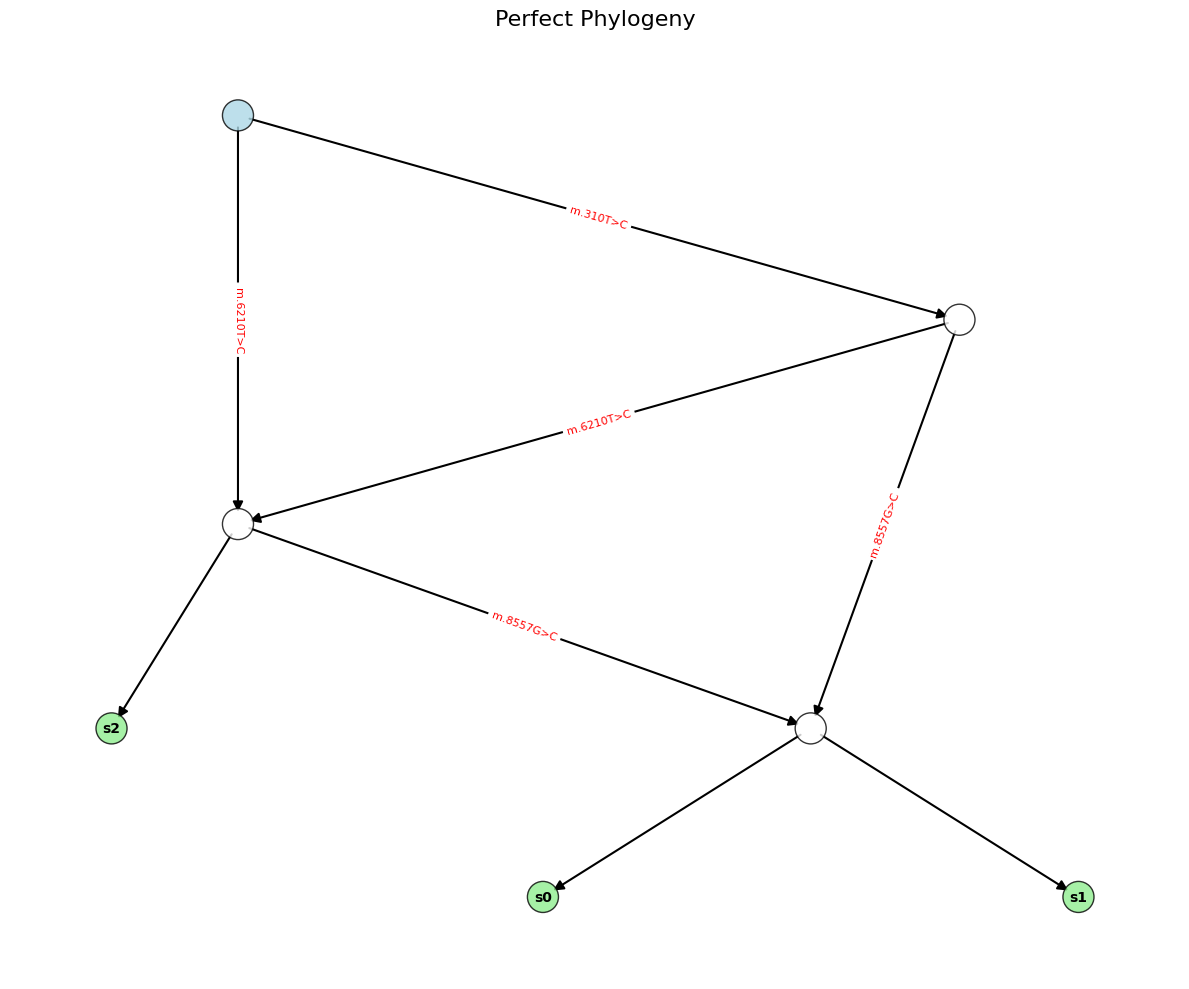

In [151]:
# Using your existing data
G = visualize_phylogeny_nx(
    k1=k,  # Your k matrix
    s=["s%d" % s for s in range(k.shape[0])],  # Sample names
    feature_dict=features_dict,  # Your feature dictionary 
    outname="networkx_phylogeny",
    layout = "hierarchical"
)

In [63]:
# plot perfect phylogeny
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import string
from matplotlib.colors import to_rgba
import matplotlib.cm as cm

def draw_annotated_phylogeny(k, feature_names=None, sample_names = None, output_file="phylogeny_tree.png"):
    """
    Draw a phylogenetic tree with feature annotations from a perfect phylogeny matrix.
    
    Parameters:
    -----------
    k : numpy.ndarray
        Perfect phylogeny matrix where rows are samples and columns are features.
        Features are represented by lowercase letters, '0' for absent features,
        and '#' as a terminator.
    sample_names : list, optional
        Names for each sample (row in k). If None, uses "Sample_i" format.
    output_file : str, optional
        Path to save the output image.
        
    Returns:
    --------
    G : networkx.DiGraph
        The graph object representing the phylogeny
    """
    if sample_names is None:
        sample_names = [f"Read_{i}" for i in range(len(k))]
    
    # Create directed graph
    G = nx.DiGraph()
    
    # Add root node
    G.add_node('root', label='Root')
    
    # Generate color map for features
    # features = list(string.ascii_lowercase[:k.shape[1]])
    colors = cm.rainbow(np.linspace(0, 1, len(features)))
    feature_colors = {feature_names[f]: colors[i] for i, f in enumerate(feature_names)}
    print(feature_colors)
    
    # Process each sample path
    for sample_idx, k_row in enumerate(k):
        sample = sample_names[sample_idx]
        
        # Create path from root to this sample
        current_node = 'root'
        for col_idx, feature in enumerate(k_row):
            if feature == b'#' or feature == '#':  # Handle both byte strings and regular strings
                break
                
            if feature == b'0' or feature == '0':
                continue
                
            # Convert feature to string if it's a byte string
            if isinstance(feature, bytes):
                feature = feature.decode('utf-8')
                feature = feature_names[feature]
                
            # Create node name: captures the path of features to this point
            next_node = f"{current_node}_{feature}"
            
            # Add edge if it doesn't exist
            if not G.has_edge(current_node, next_node):
                G.add_edge(current_node, next_node, feature=feature, 
                           color=feature_colors[feature])
                G.nodes[next_node]['label'] = ''  # Empty label for internal nodes
            
            current_node = next_node
        
        # Connect the final node to the sample
        G.add_edge(current_node, sample, feature=None, color='black')
        G.nodes[sample]['label'] = sample
    
    # Draw the graph
    plt.figure(figsize=(14, 10))
    
    # Use hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    
    # Draw nodes
    node_colors = ['lightblue' if node == 'root' else 
                   'white' if node not in sample_names else 
                   'lightgreen' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=300, alpha=0.8, linewidths=1, edgecolors='black')
    
    # Draw edges with appropriate colors
    for u, v, data in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, edge_color = 'black')
                            #    edge_color=[data.get('color', 'black')])
    
    # Draw labels for samples
    labels = {node: G.nodes[node].get('label', '') for node in G.nodes() 
              if G.nodes[node].get('label', '')}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')
    
    # Draw feature labels on edges
    edge_labels = {(u, v): data['feature'] for u, v, data in G.edges(data=True) 
                  if data.get('feature') is not None}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=12, font_color='red')
    
    # Add feature legend
    # legend_patches = [mpatches.Patch(color=to_rgba(feature_colors[feature_names[f]]), 
    #                                 label=f) for f in features 
    #                  if any(f == k_item.decode('utf-8') if isinstance(k_item, bytes) 
    #                        else f == k_item for k_row in k for k_item in k_row)]
    
    # plt.legend(handles=legend_patches, loc='best', title='Features')
    plt.axis('off')
    plt.title('Perfect Phylogeny Tree', fontsize=16)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Phylogeny tree saved to {output_file}")
    return G

In [64]:
features_dict =dict((zip(list(string.ascii_lowercase[:k.shape[1]]), df_subset.index.tolist())))

In [65]:
draw_annotated_phylogeny(k, feature_names=features_dict, sample_names = None, output_file="phylogeny_tree.png")

{'m.310T>C': array([0.5, 0. , 1. , 1. ]), 'm.6210T>C': array([0.00196078, 0.70928131, 0.92328911, 1.        ]), 'm.8557G>C': array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 'm.13376T>C': array([1.        , 0.70054304, 0.37841105, 1.        ]), 'm.15737G>A': array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])}


/Users/suhang/miniconda3/lib/python3.10/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: [1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00] is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


Phylogeny tree saved to phylogeny_tree.png


In [83]:
df


,m64011_190830_220126/100204788/ccs,m64011_190830_220126/100206196/ccs,m64011_190830_220126/100534533/ccs,m64011_190830_220126/100861704/ccs,m64011_190830_220126/101058145/ccs,m64011_190830_220126/102435679/ccs,m64011_190830_220126/102500187/ccs,m64011_190830_220126/102697770/ccs,m64011_190830_220126/104202954/ccs,m64011_190830_220126/104728867/ccs,...,m64012_190921_234837/98108076/ccs,m64012_190921_234837/98174510/ccs,m64012_190921_234837/98239318/ccs,m64012_190921_234837/98305746/ccs,m64012_190921_234837/99027574/ccs,m64012_190921_234837/99288389/ccs,m64012_190921_234837/99486072/ccs,m64012_190921_234837/99551100/ccs,m64012_190921_234837/99746239/ccs,m64012_190921_234837/99878515/ccs
variant,,,,,,,,,,,,,,,,,,,,,
m.310T>C,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,0,0,1,1,0,1
m.457C>T,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
m.6210T>C,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
m.8557G>C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
m.8558C>A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
m.13376T>C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
m.15737G>A,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# dendropy
import dendropy

def _annotate_tree_with_features(tree, binary_matrix, feature_dict, sample_names):
    """Annotate the tree with feature information"""
    # This is a simplified approach - a more complex algorithm would be needed
    # to perfectly match the original function's behavior
    
    # Map samples to leaf nodes
    leaf_nodes = {leaf.taxon.label: leaf for leaf in tree.leaf_node_iter()}
    
    # For each feature, find the node that represents its acquisition
    for feat_idx, feat_code in enumerate(feature_dict.keys()):
        feat_name = feature_dict[feat_code]
        
        # Find samples with this feature
        samples_with_feature = [sample_names[i] for i in range(len(sample_names)) 
                               if binary_matrix[i, feat_idx] == 1]
        
        if not samples_with_feature:
            continue
            
        # Find MRCA of these samples
        mrca_node = tree.mrca(taxa=[leaf_nodes[s].taxon for s in samples_with_feature])
        
        # Annotate the node
        if mrca_node:
            mrca_node.label = feat_name

binary_matrix = df.T.values
n_taxa, n_chars = df.T.shape
sample_names = df.columns.tolist()
taxa = dendropy.TaxonNamespace(sample_names)
# Create character matrix
char_matrix = dendropy.StandardCharacterMatrix()
char_matrix.taxon_namespace = taxa

for i, sample in enumerate(sample_names):
    taxon = taxa.get_taxon(label=sample)
    char_vector = char_matrix.new_sequence(taxon=taxon)
    # for j in range(len(feature_dict)):
    #     char_vector.append(dendropy.StateIdentity(symbol=str(binary_matrix[i, j])))

# Create distance matrix and tree
pdm = dendropy.calculate.phylogeneticdistance.PhylogeneticDistanceMatrix.from_character_matrix(
    char_matrix,
    distance_metric="hamming"
)
tree = pdm.nj_tree()

# # Annotate internal nodes with features
# _annotate_tree_with_features(tree, binary_matrix, feature_dict, sample_names)

# Write tree to file in various formats
tree.write(path=f"{outname}.newick", schema="newick")
tree.write(path=f"{outname}.nexus", schema="nexus")
    

AttributeError: type object 'PhylogeneticDistanceMatrix' has no attribute 'from_character_matrix'

In [340]:
# plot perfect phylogeny
import subprocess
def write_dot(k1,s,feature_dict,outname):
    '''    
    takes a k1 matrix and writes a dot source file of the node 
    connections and edges, then converts the dot to a postscript file. 
    @param k1 matrix output from perfect phylogeny checking
    @param s samples (rows)
    '''
    dot_lines = []

    for r_idx,k_row in enumerate(k1):
        for c_idx,k_i in enumerate(k_row):
            k_i = k_i.decode('utf-8')
            if k_i=='#': break
            if c_idx + 1 >= len(k_row) - 1: continue
            k_next = k_row[c_idx+1]
            k_i_name = k_i
            if c_idx==0:
                dot_lines.append('\troot [label=""];\n')
                dot_lines.append('\troot -> node_%s [label="%s"];\n' % (k_i_name,k_i_name))
            if k_next=='#':
                dot_lines.append('\tnode_%s [label=""];\n' % k_i_name)
                dot_lines.append('\tnode_%s -> %s;\n' % (k_i_name,s[r_idx]))
                break                
            dot_lines.append('\tnode_%s [label=""];\n\tnode_%s [label=""];\n' % (k_i_name,k_next))
            dot_lines.append('\tnode_%s -> node_%s [label="%s"];\n' % (k_i_name,k_next,k_next))
   
    dot_lines = np.unique(np.array(dot_lines))
    with open('%s.dot'%outname,'w') as fout:
        fout.write('digraph {\n')
        fout.write('\tgraph[size="7.75,10.25"]\n')
        for line in dot_lines:
            fout.write(line)
        fout.write('}\n')

    subprocess.call(['dot','-Tps','%s.dot'%outname],stdout=open('%s.ps'%outname,'w')) 

In [341]:
 write_dot(k,["s%d" % s for s in range(k.shape[0])],features_dict,"perfectphylogeny.test")

Error: perfectphylogeny.test.dot: syntax error in line 3 near '''


In [117]:
# df_subset.columns